### **libs**

In [ ]:
!pip install --upgrade calflops

In [ ]:
import pandas as pd
import geopandas
import numpy as np
import os

from calflops import calculate_flops

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

import ast
import math
import random
import time
import datetime
import itertools
from itertools import cycle
from tabulate import tabulate

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold

### **configs**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("Treinamento usando GPU.")
else:
    print("Treinamento usando CPU.")

Treinamento usando GPU.


In [ ]:
seed = 18
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### **utils**

#### **printing metrics**

In [ ]:
id_to_name = {
    '0': 'Community',
    '1': 'Entertainment',
    '2': 'Food',
    '3': 'Nightlife',
    '4': 'Outdoors',
    '5': 'Shopping',
    '6': 'Travel'
}

In [ ]:
def print_classification_report_train(y_true_category, y_pred_category, y_true_next, y_pred_next, id_to_name):
    category_report = classification_report(y_true_category, y_pred_category, zero_division=1, output_dict=True)
    next_report = classification_report(y_true_next, y_pred_next, zero_division=1, output_dict=True)

    category_df = pd.DataFrame(category_report).transpose()
    next_df = pd.DataFrame(next_report).transpose()

    category_df = category_df.drop(columns='support')
    category_df = category_df.drop(index=['weighted avg', 'accuracy'])

    next_df = next_df.drop(columns='support')
    next_df = next_df.drop(index=['weighted avg', 'accuracy'])

    category_df.rename(index=id_to_name, inplace=True)
    next_df.rename(index=id_to_name, inplace=True)

    category_df = category_df.transpose()
    next_df = next_df.transpose()

    category_df = category_df.map(lambda x: f"{x * 100:.1f}")
    next_df = next_df.map(lambda x: f"{x * 100:.1f}")

    print("\ncategory train metrics:")
    print(category_df.to_string())

    print("\n next train metrics:")
    print(next_df.to_string())

In [ ]:
def print_classification_report_test(y_true, y_pred, id_to_name, task_name):
    report = classification_report(y_true, y_pred, zero_division=1, output_dict=True)

    metrics_df = pd.DataFrame(report).transpose()
    metrics_df = metrics_df.drop(columns='support')
    metrics_df = metrics_df.drop(index=['weighted avg', 'accuracy'])

    metrics_df.rename(index=id_to_name, inplace=True)
    metrics_df = metrics_df.transpose()

    metrics_df = metrics_df.map(lambda x: f"{x * 100:.1f}")

    print(f'{task_name} test metrics:')
    print(metrics_df.to_string() + '\n')

In [ ]:
def print_classification_report_val(y_true, y_pred, id_to_name, task_name):
    report = classification_report(y_true, y_pred, zero_division=1, output_dict=True)

    metrics_df = pd.DataFrame(report).transpose()
    metrics_df = metrics_df.drop(columns='support')
    metrics_df = metrics_df.drop(index=['weighted avg', 'accuracy'])

    metrics_df.rename(index=id_to_name, inplace=True)
    metrics_df = metrics_df.transpose()

    metrics_df = metrics_df.map(lambda x: f"{x * 100:.1f}")

    print(f'validação {task_name} metrics:')
    print(metrics_df.to_string() + '\n')

#### **print losses**

In [ ]:
def print_train_losses(epoch, num_epochs, mtl_loss, next_loss, category_losss):
  print(f'\nEPOCH {epoch + 1}/{num_epochs}:')
  print(f'mtl loss: {mtl_loss:.1f}')
  print(f'next loss: {next_loss:.1f}')
  print(f'category loss: {category_losss:.1f}')

#### **plotting graphics**

In [ ]:
def plot_graphic_metrics_by_fold(task_name, metrics_df):
    metrics = ['precision', 'recall', 'f1-score']
    cores = ['green', 'purple', 'yellow']
    plt.figure(figsize=(18, 6))

    sns.set(style="whitegrid")

    for i, metric in enumerate(metrics):
        plt.subplot(1, 3, i + 1)
        sns.boxplot(y=metric, data=metrics_df, color=cores[i])
        plt.title(f'{metric.capitalize()} por Fold na Tarefa {task_name.upper()}')
        plt.ylabel(metric.capitalize())
        plt.ylim(0, 0.60)
        plt.grid(False)

    plt.tight_layout()
    plt.show()

#### **calculating metrics**

In [ ]:
def calculate_metrics_by_fold(fold_results, task_name):
    metrics = {
        'fold': [],
        'precision': [],
        'recall': [],
        'f1-score': []
    }

    for fold, results in fold_results.items():
        y_true = results[f'test_{task_name}_true']
        y_pred = results[f'test_{task_name}_pred']

        report = classification_report(y_true, y_pred, output_dict=True, zero_division=1)

        metrics['fold'].append(fold)
        metrics['precision'].append(report['macro avg']['precision'])
        metrics['recall'].append(report['macro avg']['recall'])
        metrics['f1-score'].append(report['macro avg']['f1-score'])

    return pd.DataFrame(metrics)

### **tasks inputs**

In [ ]:
def x_y_to_tensor(x, y, task_name):
  x = torch.tensor(x.values, dtype=torch.float)
  y = torch.tensor(y.values, dtype=torch.long)

  # print(x.shape, y.shape)

  if task_name == 'next':
    x = x.view(-1, 9, 100)
  else:
     x = x.view(-1, 1, 100)


  x.to(device)
  y.to(device)

  return x, y

def map_categories(y):
  id_to_name = {
    '0': 'Community',
    '1': 'Entertainment',
    '2': 'Food',
    '3': 'Nightlife',
    '4': 'Outdoors',
    '5': 'Shopping',
    '6': 'Travel',
    '7': 'None'
  }

  name_to_id = {name: int(id) for id, name in id_to_name.items()}
  try:
    y_encoded = np.array([[name_to_id[yi] for yi in row] for _, row in y.iterrows()])
  except:
    y_encoded = y.map(name_to_id)

  return y_encoded

#### **nextpoi input**

In [ ]:
df_nextpoi_input = pd.read_csv(path_nextpoi_input_alabama)
print(df_nextpoi_input.shape)

usersids = df_nextpoi_input['userid'].unique().size
print(usersids)

(8637, 910)
418


In [ ]:
target = df_nextpoi_input.columns[900:-1]

x_nextpoi = df_nextpoi_input.drop(target, axis=1)
y_nextpoi = df_nextpoi_input[target]
y_nextpoi = y_nextpoi.fillna('None')
y_nextpoi = map_categories(y_nextpoi)
y_nextpoi = pd.DataFrame(y_nextpoi)
print(x_nextpoi.shape, y_nextpoi.shape)

(8637, 901) (8637, 9)


#### **categorypoi input**

In [ ]:
categorypoi_input = pd.read_csv(path_categorypoi_input_alabama)
print(categorypoi_input.shape)

placesids = categorypoi_input['placeid'].unique()
placesids = placesids.astype(int)
print(len(placesids))

categorypoi_input = categorypoi_input.set_index('placeid')
print(categorypoi_input.shape)

(9090, 102)
9090
(9090, 101)


In [ ]:
x_categorypoi = categorypoi_input.drop('category', axis=1)
y_categorypoi = categorypoi_input['category']

y_categorypoi = map_categories(y_categorypoi)

print(x_categorypoi.shape, y_categorypoi.shape)

(9090, 100) (9090,)


### **dataset and dataloaders**

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, input_features, true_y):
        self.input_features = input_features
        self.true_y = true_y

    def __len__(self):
        return len(self.input_features)

    def __getitem__(self, idx):
        sample = {
            'x': self.input_features[idx],
            'y': self.true_y[idx]
        }
        return sample

In [ ]:
def input_to_dataloader(x, y, batch_size=32, shuffle=True):
  dataset = CustomDataset(x, y)
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
  return dataloader

### **model**

#### **nextpoi arch**

In [ ]:
class NextPoinet(nn.Module):
    def __init__(self, embed_dim, num_classes, num_heads, seq_length, dropout=0.1):
        super(NextPoinet, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=embed_dim, hidden_size=embed_dim, batch_first=True)

        self.multihead_attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)

        self.feed_forward1 = nn.Sequential(
            nn.Linear(self.embed_dim, self.embed_dim * 4),
            nn.LeakyReLU(),
            nn.Linear(self.embed_dim * 4, self.embed_dim)
        )
        self.layer_norm1 = nn.LayerNorm(embed_dim)

        self.feed_forward2 = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.LeakyReLU(),
            nn.Linear(embed_dim * 4, embed_dim)
        )
        self.layer_norm2 = nn.LayerNorm(embed_dim)

        self.linear_layers = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        batch_size, seq_length, _ = x.size()

        lstm_out, _ = self.lstm(x)

        attn_mask = torch.triu(torch.ones(seq_length, seq_length), diagonal=1).bool().to(x.device)
        attn_output, _ = self.multihead_attn(lstm_out, lstm_out, lstm_out, attn_mask=attn_mask)

        x = lstm_out + attn_output

        x = self.layer_norm1(x)
        x = self.feed_forward1(x)

        x = self.layer_norm2(x)
        x = self.feed_forward2(x)

        x = self.linear_layers(x)

        return x

#### **categorypoi arch**

In [ ]:
class CategoryPoinet(nn.Module):
    def __init__(self, input_dim, num_classes, num_layers, num_heads, dropout=0.1):
        super(CategoryPoinet, self).__init__()

        encoder_layer = nn.TransformerEncoderLayer(input_dim, num_heads, dim_feedforward=input_dim, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.fc = nn.Sequential(
            nn.Linear(input_dim, num_classes),
            nn.LeakyReLU(),
        )

    def forward(self, x):
        x = self.transformer_encoder(x)
        x = self.fc(x)

        B, T, C = x.shape
        x = x.view(B, T * C)

        return x

#### **mtl arch**

In [ ]:
class MTLnet(nn.Module):
    def __init__(self, feature_size, shared_layer_size, num_classes, num_heads, num_layers, seq_length, num_linear_layers):
        super(MTLnet, self).__init__()

        self.feature_size = feature_size
        self.embedding = torch.nn.Embedding(1, feature_size)

        linear_layers = [] # lista de layers

         # add primeira camada de input (feature_size -> shared_layer_size)
        linear_layers.append(nn.Linear(feature_size, shared_layer_size))
        linear_layers.append(nn.LeakyReLU())
        linear_layers.append(nn.Dropout())

        # add layers intermediarias
        for _ in range(num_linear_layers - 1):
            linear_layers.append(nn.Linear(shared_layer_size, shared_layer_size))
            linear_layers.append(nn.LeakyReLU())
            linear_layers.append(nn.Dropout())

        # cria o sequential igual antes
        self.linear_layer = nn.Sequential(*linear_layers)

        # self.linear_layer = nn.Sequential(
        #   nn.Linear(feature_size, shared_layer_size),
        #   nn.LeakyReLU(),
        #   nn.Dropout(),

        #   nn.Linear(shared_layer_size, shared_layer_size),
        #   nn.LeakyReLU(),
        #   nn.Dropout(),

        #   nn.Linear(shared_layer_size, shared_layer_size),
        #   nn.LeakyReLU(),
        #   nn.Dropout(),

        #   nn.Linear(shared_layer_size, shared_layer_size),
        #   nn.LeakyReLU(),
        #   nn.Dropout(),
        # )

        self.category_poi = CategoryPoinet(shared_layer_size, num_classes, num_layers, num_heads)
        self.next_poi = NextPoinet(shared_layer_size, num_classes, num_heads, seq_length)

    def forward(self, x1, x2):
        idxs = x2.sum(-1) == 0

        if torch.any(idxs):
          replace_tensor = self.embedding(torch.tensor(0, dtype=torch.long).to(device))
          x2[idxs] = replace_tensor

        shared_output1 = self.linear_layer(x1)
        shared_output2 = self.linear_layer(x2)

        out1 = self.category_poi(shared_output1)
        out2 = self.next_poi(shared_output2)

        return out1, out2

    def forward_nextpoi(self, x):
        idxs = x.sum(-1) == 0
        x[idxs] = self.embedding(torch.tensor(0,dtype=torch.long).to(device))

        shared_output = self.linear_layer(x)

        out = self.next_poi(shared_output)

        return out

    def forward_categorypoi(self, x):
        shared_output = self.linear_layer(x)

        out = self.category_poi(shared_output)

        return out

### **FLOPS calculate**

#### calculate

In [ ]:
model = MTLnet(
      feature_size=100,
      shared_layer_size=256,
      num_classes=7,
      num_heads=8,
      num_layers=4,
      seq_length=9,
      num_linear_layers=4,
    )

model = model.to(device)

In [ ]:
x_nextpoi_ = x_nextpoi.copy()
x_nextpoi_.userid = x_nextpoi_.userid.astype(int)
usersids = x_nextpoi_['userid'].unique()

train_user_index, test_user_index = train_test_split(usersids, test_size=0.25, random_state=42)

train_place_index, test_place_index = train_test_split(x_categorypoi.index, test_size=0.25, random_state=42)

train_user_index, val_user_index = train_test_split(train_user_index, test_size=0.25, random_state=42)
train_place_index, val_place_index = train_test_split(train_place_index, test_size=0.25, random_state=42)

train_index_next = x_nextpoi_[x_nextpoi_['userid'].isin(train_user_index)].index
x_nextpoi_ = x_nextpoi_.drop('userid', axis=1)

y_nextpoi_ = y_nextpoi.copy()
x_nextpoi_, y_nextpoi_ = x_y_to_tensor(x_nextpoi_, y_nextpoi_, 'next')
x_train_next = x_nextpoi_[train_index_next]
y_train_next = y_nextpoi_[train_index_next]

x_categorypoi_ = x_categorypoi.copy()
y_categorypoi_ = y_categorypoi.copy()
x_categorypoi_, y_categorypoi_ = x_y_to_tensor(x_categorypoi_, y_categorypoi_, 'category')

if isinstance(x_categorypoi_, torch.Tensor):
    train_place_index, test_place_index = train_test_split(torch.arange(x_categorypoi_.size(0)), test_size=0.25, random_state=42)
    train_place_index, val_place_index = train_test_split(train_place_index, test_size=0.25, random_state=42)

    x_train_category = x_categorypoi_[train_place_index]
    y_train_category = y_categorypoi_[train_place_index]

    x_test_category = x_categorypoi_[test_place_index]
    y_test_category = y_categorypoi_[test_place_index]

    x_val_category = x_categorypoi_[val_place_index]
    y_val_category = y_categorypoi_[val_place_index]
else:
    raise TypeError("x_categorypoi should be a tensor")

next_dataloader_train = input_to_dataloader(x_train_next, y_train_next)
category_dataloader_train = input_to_dataloader(x_train_category, y_train_category)


In [ ]:
print("Tamanho de x_categorypoi:", x_categorypoi.shape[0])
print("train_place_index:", train_place_index)
print("test_place_index:", test_place_index)
print("val_place_index:", val_place_index)
print(type(x_categorypoi))

Tamanho de x_categorypoi: 9090
train_place_index: tensor([2941, 4620, 7943,  ..., 4455, 7486, 8697])
test_place_index: tensor([3290, 2554, 3065,  ..., 4165, 3307, 1302])
val_place_index: tensor([8328, 4452, 4330,  ..., 1453, 1439, 5042])
<class 'pandas.core.frame.DataFrame'>


In [ ]:
first_batch_nextpoi = next(iter(next_dataloader_train))
x1 = first_batch_nextpoi['x']

first_batch_categorypoi = next(iter(category_dataloader_train))
x2 = first_batch_categorypoi['x']

x1 = x1.to(device)
x2 = x2.to(device)

In [ ]:
flops, macs, params = calculate_flops(model=model,
                                          kwargs={'x1': x1, 'x2': x2},
                                          print_results=False)

print("MTL-Poi FLOPs: %s   MACs: %s   Params: %s" %(flops, macs, params))

flops = {
        'flops': flops,
        'macs': macs,
        'params': params,
}

MTL-Poi FLOPs: 1.17 GFLOPS   MACs: 566.62 MMACs   Params: 3.65 M


#### saving result

In [ ]:
mlflow.end_run()

In [ ]:
import tempfile
import os

with mlflow.start_run(run_name='mtlpoi - FLOPS'):
    flops_df = pd.DataFrame.from_dict(flops, orient='index')

    flops_df_path = '/tmp/flops.csv'
    flops_df.to_csv(flops_df_path)

    mlflow.log_artifact(flops_df_path, "FLOPS")

2024/10/29 16:28:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run mtlpoi - FLOPS at: https://dagshub.com/ingredalmeida1/poc.mlflow/#/experiments/1/runs/df3a88f2175649ddad73b09b4d536078.
2024/10/29 16:28:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/ingredalmeida1/poc.mlflow/#/experiments/1.


### **train and test**

#### **val function**

In [ ]:
def val_model(model, loss_function, one_hot, dataloader, id_to_name, task_name):
  y_true = []
  y_pred = []
  running_loss = 0.0
  steps = 0

  model.eval()

  with torch.no_grad():
      for data in dataloader:
          x, y = data['x'], data['y']
          x = x.to(device)
          y = y.to(device)

          if task_name == 'next':
            out = model.forward_nextpoi(x)

            B, S, _ = out.shape
            out = out.view(B * S , -1)
            y = y.view(B * S , -1)

            valid_samples = y < 7
            expanded_mask = valid_samples.expand(-1, out.shape[1])

            y = y[valid_samples]
            out = out[expanded_mask].view(-1, 7)

            predicted = torch.argmax(out, dim=-1)
            y_true.extend(y.tolist())
            y_pred.extend(predicted.tolist())

            # y_one_hot = one_hot[y]
            loss = loss_function(out, y)
            running_loss += loss.item()
            steps += 1

          else:
            out = model.forward_categorypoi(x)

            predicted = torch.argmax(out, dim=-1)
            y_true.extend(y.tolist())
            y_pred.extend(predicted.tolist())

            y_one_hot = one_hot[y]
            loss = loss_function(out, y_one_hot)
            running_loss += loss.item()
            steps += 1

  average_loss = running_loss / steps if steps > 0 else 0.0

  print_classification_report_val(y_true, y_pred, id_to_name, task_name)

  return y_true, y_pred, average_loss

#### **test function**

In [ ]:
def test_model(model, dataloader, id_to_name, task_name):
  print(f'\nTESTE {task_name.upper()}\n')

  y_true = []
  y_pred = []

  model.eval()

  with torch.no_grad():
      for data in dataloader:
          x, y = data['x'], data['y']
          x = x.to(device)
          y = y.to(device)

          if task_name == 'next':
            out = model.forward_nextpoi(x)
          else:
            out = model.forward_categorypoi(x)

          predicted = torch.argmax(out, dim=-1)

          valid_samples = y < 7

          y = y[valid_samples]
          predicted = predicted[valid_samples]

          y_true.extend(y.view(-1).tolist())
          y_pred.extend(predicted.view(-1).tolist())

      print_classification_report_test(y_true, y_pred, id_to_name, task_name)
      print()

  return y_true, y_pred

#### **train function**

In [ ]:
def train_model_by_fold(model, optimizer, scheduler, next_dataloader_train, category_dataloader_train, next_dataloader_val,
                        category_dataloader_val, loss_function, one_hot, num_epochs, id_to_name, print_interval=1):
    mtl_train_losses = []
    next_losses = []
    category_losses = []
    next_val_losses = []
    category_val_losses = []

    for epoch in range(num_epochs):
        model.train()

        running_loss = 0.0
        next_running_loss = 0.0
        category_running_loss = 0.0

        y_true_category = []
        y_pred_category = []
        y_true_next = []
        y_pred_next = []

        steps = 0
        category_iter = cycle(category_dataloader_train)

        for data_next in next_dataloader_train:
            data_category = next(category_iter)
            optimizer.zero_grad()

            x_next, y_next = data_next['x'], data_next['y']

            x_next = x_next.to(device)
            y_next = y_next.to(device)

            x_category, y_category = data_category['x'], data_category['y']
            x_category = x_category.to(device)
            y_category = y_category.to(device)

            out_category, out_next = model(x_category, x_next)

            # metrics

            category_predicted = torch.argmax(out_category, dim=-1)

            y_true_category.extend(y_category.tolist())
            y_pred_category.extend(category_predicted.tolist())

            B, S, _ = out_next.shape

            out_next = out_next.view(B * S , -1)
            y_next = y_next.view(B * S , -1)

            valid_samples = y_next < 7
            expanded_mask = valid_samples.expand(-1, out_next.shape[1])

            y_next = y_next[valid_samples]
            out_next = out_next[expanded_mask].view(-1, 7)

            next_predicted = torch.argmax(out_next, dim=-1)

            y_true_next.extend(y_next.view(-1).tolist())
            y_pred_next.extend(next_predicted.view(-1).tolist())

            # losses
            y_next = one_hot[y_next]
            loss_next = loss_function(out_next, y_next)

            y_category = one_hot[y_category]
            loss_category = loss_function(out_category, y_category)

            loss = loss_next + loss_category
            loss.backward()

            optimizer.step()

            steps += 1
            running_loss += loss.item()
            next_running_loss += loss_next.item()
            category_running_loss += loss_category.item()

        if steps > 0:
            if (epoch + 1) % print_interval == 0 or epoch == 0:
                mtl_loss_by_epoch = running_loss / steps
                next_loss_by_epoch = next_running_loss / steps
                category_loss_by_epoch = category_running_loss / steps

                mtl_train_losses.append(mtl_loss_by_epoch)
                next_losses.append(next_loss_by_epoch)
                category_losses.append(category_loss_by_epoch)
                print_train_losses(epoch, num_epochs, mtl_loss_by_epoch, next_loss_by_epoch, category_loss_by_epoch)
                print_classification_report_train(y_true_category, y_pred_category, y_true_next, y_pred_next, id_to_name)
                print()
                print("-" * 110)
                print()

                model.eval()

                # validação category
                val_y_true_category, val_y_pred_category, category_val_loss = val_model(model, loss_function, one_hot, category_dataloader_val, id_to_name, 'category')
                category_val_loss_by_epoch = category_val_loss / steps
                category_val_losses.append(category_val_loss_by_epoch)
                # print(f'category val losses: {category_val_losses}')

                # validação next
                val_y_true_next, val_y_pred_next, next_val_loss = val_model(model, loss_function, one_hot, next_dataloader_val, id_to_name, 'next')
                next_val_loss_by_epoch = next_val_loss / steps
                next_val_losses.append(next_val_loss_by_epoch)
                # print(f'next val losses: {next_val_losses}\n')
                print("*" * 110)

        scheduler.step(mtl_loss_by_epoch)

    results = {'mtl_train_losses': mtl_train_losses,
               'next_losses': next_losses,
               'category_losses': category_losses,
               'next_val_losses': next_val_losses,
               'category_val_losses': category_val_losses,
               'y_true_category': y_true_category,
               'y_pred_category': y_pred_category,
               'y_true_next': y_true_next,
               'y_pred_next': y_pred_next,
               'val_y_true_category': val_y_true_category,
               'val_y_pred_category': val_y_pred_category,
               'val_y_true_next': val_y_true_next,
               'val_y_pred_next': val_y_pred_next
               }
    return results

#### **k-fold train and test**

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
num_classes = 7
one_hot = torch.eye(num_classes).to(device)
loss_function = nn.CrossEntropyLoss()
num_epochs = 100
fold = 1
print_interval = 1

try:
  x_nextpoi.userid = x_nextpoi.userid.astype(int)
  usersids = x_nextpoi['userid'].unique()
except:
  pass
fold_results_test = {}

fold_results_train = {}
fold_losses_train = {}

fold_results_val = {}
fold_losses_val = {}

flops_pre_train = {}
flops_pos_train = {}

for (train_user_index, test_user_index), (train_place_index, test_place_index) in zip(kf.split(usersids), kf.split(x_categorypoi)):
    print("#" * 110)
    print(f'FOLD {fold}:')

    try:
      x_nextpoi = _x_nextpoi.copy()
      y_nextpoi = _y_nextpoi.copy()
      x_categorypoi = _x_categorypoi.copy()
      y_categorypoi = _y_categorypoi.copy()
    except:
      _x_nextpoi = x_nextpoi.copy()
      _y_nextpoi = y_nextpoi.copy()
      _x_categorypoi = x_categorypoi.copy()
      _y_categorypoi = y_categorypoi.copy()

    model = MTLnet(
      feature_size=100,
      shared_layer_size=256,
      num_classes=num_classes,
      num_heads=8,
      num_layers=4,
      seq_length=9,
      num_linear_layers=4,
    )

    model = model.to(device)

    optimizer = optim.SGD(model.parameters(), lr=0.06, weight_decay=1e-6)
    scheduler = ReduceLROnPlateau(optimizer, 'min')

    # val e train
    train_user_index, val_user_index = train_test_split(train_user_index, test_size=0.25, random_state=42)
    train_place_index, val_place_index = train_test_split(train_place_index, test_size=0.25, random_state=42)

    # indexs para o split pro nextpoi
    train_index_next = x_nextpoi[x_nextpoi['userid'].isin(usersids[train_user_index])].index
    val_index_next = x_nextpoi[x_nextpoi['userid'].isin(usersids[val_user_index])].index
    test_index_next = x_nextpoi[x_nextpoi['userid'].isin(usersids[test_user_index])].index
    x_nextpoi = x_nextpoi.drop('userid', axis=1)

    # train, test e val pro nextpoi
    x_nextpoi, y_nextpoi = x_y_to_tensor(x_nextpoi, y_nextpoi, 'next')
    x_train_next, x_test_next, x_val_next = x_nextpoi[train_index_next], x_nextpoi[test_index_next], x_nextpoi[val_index_next]
    y_train_next, y_test_next, y_val_next = y_nextpoi[train_index_next], y_nextpoi[test_index_next], y_nextpoi[val_index_next]

    # train, test e val pro categorypoi
    x_categorypoi, y_categorypoi = x_y_to_tensor(x_categorypoi, y_categorypoi, 'category')
    x_train_category, x_test_category, x_val_category = x_categorypoi[train_place_index], x_categorypoi[test_place_index], x_categorypoi[val_place_index]
    y_train_category, y_test_category, y_val_category = y_categorypoi[train_place_index], y_categorypoi[test_place_index], y_categorypoi[val_place_index]

    # dataloaders nextpoi
    next_dataloader_train = input_to_dataloader(x_train_next, y_train_next)
    next_dataloader_test = input_to_dataloader(x_test_next, y_test_next)
    next_dataloader_val = input_to_dataloader(x_val_next, y_val_next)

    # dataloaders categorypoi
    category_dataloader_train = input_to_dataloader(x_train_category, y_train_category)
    category_dataloader_test = input_to_dataloader(x_test_category, y_test_category)
    category_dataloader_val = input_to_dataloader(x_val_category, y_val_category)

    fold_results_test[fold] = {
        'test_next_true': [],
        'test_next_pred': [],
        'test_category_true': [],
        'test_category_pred': []
    }

    fold_results_train[fold] = {
        'train_next_true': [],
        'train_next_pred': [],
        'train_category_true': [],
        'train_category_pred': [],
    }

    fold_results_val[fold] = {
        'val_next_true': [],
        'val_next_pred': [],
        'val_category_true': [],
        'val_category_pred': [],
    }

    fold_losses_train[fold] = {
        'mtl_train_losses': [],
        'next_losses': [],
        'category_losses': []
    }

    fold_losses_val[fold] = {
        'next_val_losses': [],
        'category_val_losses': [],
    }

    # train mtl model
    results = train_model_by_fold(model, optimizer, scheduler, next_dataloader_train, category_dataloader_train, next_dataloader_val,
                                  category_dataloader_val, loss_function, one_hot, num_epochs, id_to_name)

    fold_losses_train[fold]['mtl_train_losses'] = results['mtl_train_losses']
    fold_losses_train[fold]['next_losses'] = results['next_losses']
    fold_losses_train[fold]['category_losses'] = results['category_losses']

    fold_losses_val[fold]['next_val_losses'] = results['next_val_losses']
    fold_losses_val[fold]['category_val_losses'] = results['category_val_losses']

    fold_results_train[fold]['train_next_true'] = results['y_true_next']
    fold_results_train[fold]['train_next_pred'] = results['y_pred_next']
    fold_results_train[fold]['train_category_true'] = results['y_true_category']
    fold_results_train[fold]['train_category_pred'] = results['y_pred_category']

    fold_results_val[fold]['val_next_true'] = results['val_y_true_next']
    fold_results_val[fold]['val_next_pred'] = results['val_y_pred_next']
    fold_results_val[fold]['val_category_true'] = results['val_y_true_category']
    fold_results_val[fold]['val_category_pred'] = results['val_y_pred_category']

    # test next
    start_next_pred = time.time()
    y_true_test_next, y_pred_test_next = test_model(model, next_dataloader_test, id_to_name, 'next')
    fold_results_test[fold]['test_next_true'] = y_true_test_next
    fold_results_test[fold]['test_next_pred'] = y_pred_test_next
    end_next_pred = time.time()
    next_pred_time = end_next_pred - start_next_pred

    # test category
    start_category_pred = time.time()
    y_true_test_category, y_pred_test_category = test_model(model, category_dataloader_test, id_to_name, 'category')
    fold_results_test[fold]['test_category_true'] = y_true_test_category
    fold_results_test[fold]['test_category_pred'] = y_pred_test_category
    end_category_pred = time.time()
    category_pred_time = end_category_pred - start_category_pred

    fold += 1

A saída de streaming foi truncada nas últimas 5000 linhas.

validação next metrics:
          Community Entertainment  Food Nightlife Outdoors Shopping Travel macro avg
precision      47.9          61.9  46.5      18.5    100.0     30.9   33.3      48.4
recall         42.5           9.7  55.9       1.3      0.0     47.6    0.8      22.5
f1-score       45.0          16.8  50.7       2.4      0.0     37.5    1.5      22.0

**************************************************************************************************************

EPOCH 51/100:
mtl loss: 2.8
next loss: 1.5
category loss: 1.3

category train metrics:
          Community Entertainment  Food Nightlife Outdoors Shopping Travel macro avg
precision      47.4          53.1  59.0      37.7     23.3     52.9   18.2      41.6
recall         38.1          17.0  66.6      15.4      4.1     71.0    0.8      30.4
f1-score       42.2          25.8  62.6      21.9      7.0     60.6    1.6      31.7

 next train metrics:
          Comm

### **analysis of results**

#### **distribution of test metrics by fold**

##### **next**

In [ ]:
metrics_df_next = calculate_metrics_by_fold(fold_results_test, 'next')
print('nextpoi test metrics by fold:\n')
print(metrics_df_next)

nextpoi test metrics by fold:

   fold  precision    recall  f1-score
0     1   0.447335  0.215704  0.215361
1     2   0.486749  0.207020  0.203759
2     3   0.290529  0.214127  0.215303
3     4   0.323248  0.233301  0.235013
4     5   0.433506  0.220788  0.213976


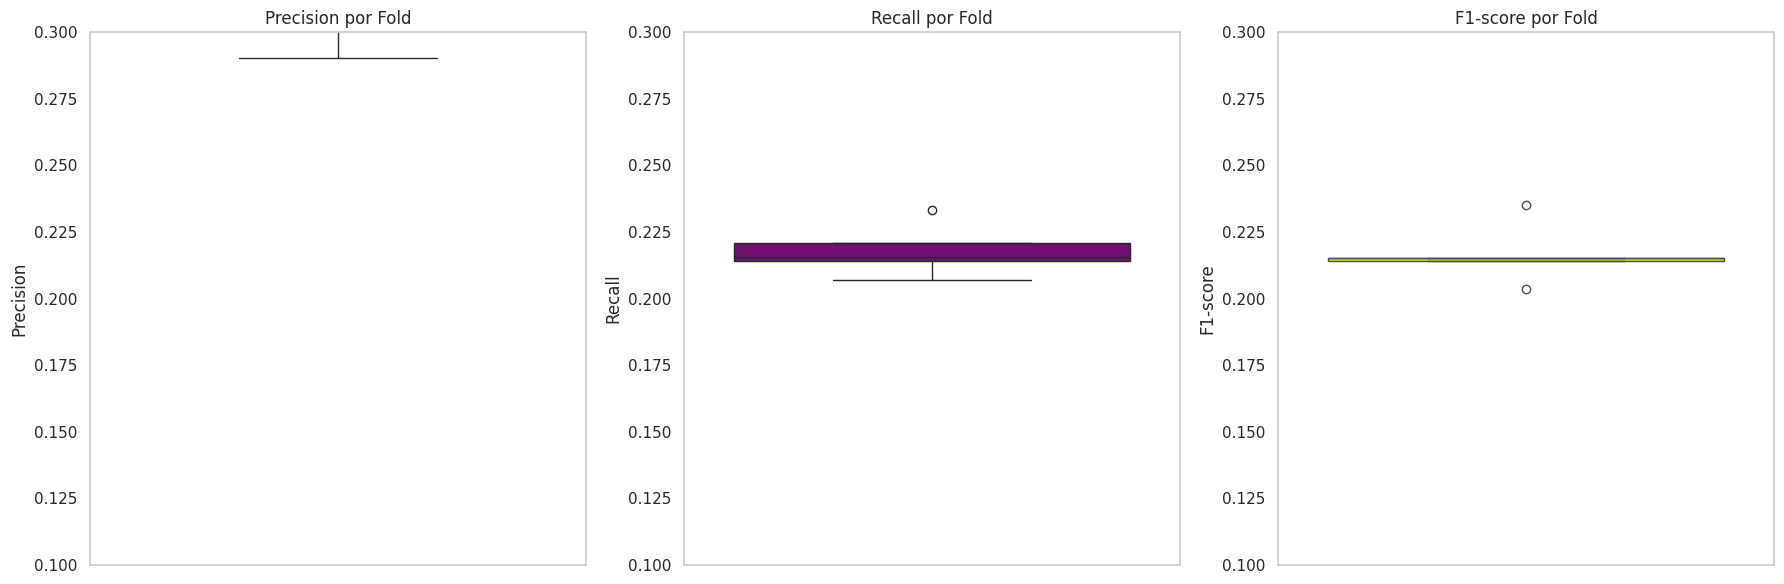

In [ ]:
metrics = ['precision', 'recall', 'f1-score']
cores = ['green', 'purple', 'yellow']
plt.figure(figsize=(18, 6))

sns.set(style="whitegrid")

for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(y=metric, data=metrics_df_next, color=cores[i])
    plt.title(f'{metric.capitalize()} por Fold')
    plt.ylabel(metric.capitalize())
    plt.ylim(0.1, 0.3)
    plt.grid(False)

plt.tight_layout()

metric_by_fold_nextpoi = '/tmp/metric-by-fold-nextpoi.png'
plt.savefig(metric_by_fold_nextpoi)

plt.show()

##### **category**

In [ ]:
metrics_df_category = calculate_metrics_by_fold(fold_results_test, 'category')
print('categorypoi test metrics by fold:\n')
print(metrics_df_category)

categorypoi test metrics by fold:

   fold  precision    recall  f1-score
0     1   0.428502  0.280640  0.303094
1     2   0.391026  0.263634  0.272980
2     3   0.363393  0.285236  0.292989
3     4   0.384526  0.304431  0.317840
4     5   0.398936  0.283586  0.293468


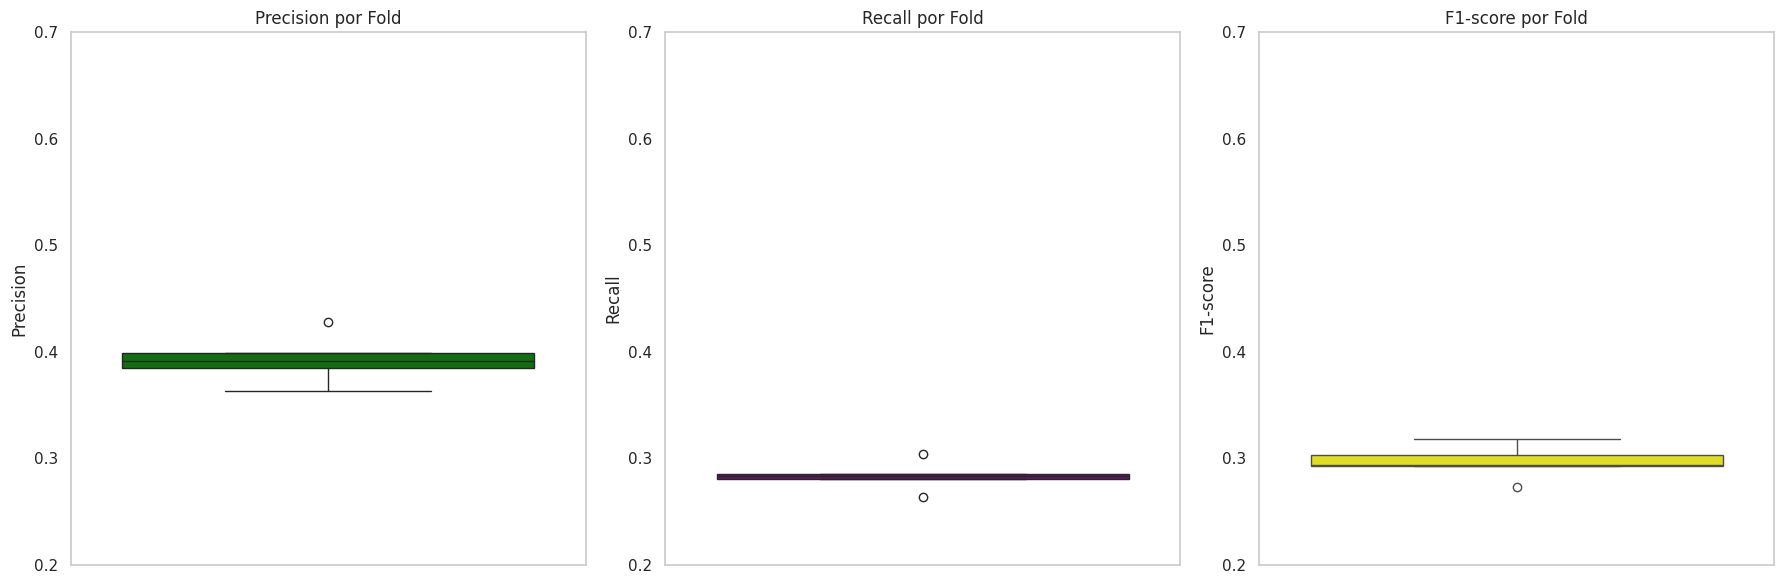

In [ ]:
metrics = ['precision', 'recall', 'f1-score']
cores = ['green', 'purple', 'yellow']
plt.figure(figsize=(18, 6))

sns.set(style="whitegrid")

for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(y=metric, data=metrics_df_category, color=cores[i])
    plt.title(f'{metric.capitalize()} por Fold')
    plt.ylabel(metric.capitalize())
    plt.ylim(0.2, 0.7)
    plt.grid(False)

plt.tight_layout()

metric_by_fold_categorypoi = '/tmp/metric-by-fold-categorypoi.png'
plt.savefig(metric_by_fold_categorypoi)

plt.show()

#### **test metrics in each fold**

In [ ]:
for fold in fold_results_test:
  print('"' * 85)
  print(f'FOLD {fold}\n')

  y_true_next = fold_results_test[fold]['test_next_true']
  y_pred_next = fold_results_test[fold]['test_next_pred']

  y_true_category = fold_results_test[fold]['test_category_true']
  y_pred_category = fold_results_test[fold]['test_category_pred']

  print_classification_report_test(y_true_next, y_pred_next, id_to_name, 'next')
  print_classification_report_test(y_true_category, y_pred_category, id_to_name, 'category')
  print()

"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
FOLD 1

next test metrics:
          Community Entertainment  Food Nightlife Outdoors Shopping Travel macro avg
precision      45.7          39.0  39.7      32.3    100.0     36.5   19.9      44.7
recall         41.1           7.3  67.7       3.4      0.0     26.1    5.4      21.6
f1-score       43.3          12.3  50.1       6.2      0.0     30.4    8.5      21.5

category test metrics:
          Community Entertainment  Food Nightlife Outdoors Shopping Travel macro avg
precision      51.2          63.6  54.1      52.9     14.7     43.3   20.0      42.9
recall         28.2          14.1  59.7      20.0      6.3     64.4    3.7      28.1
f1-score       36.4          23.1  56.8      29.0      8.8     51.8    6.2      30.3


"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
FOLD 2

next test metrics:
          Community Entertainment  Food Nightlife Outdoors Shopping 

#### **evolution of losses**

##### **during training**

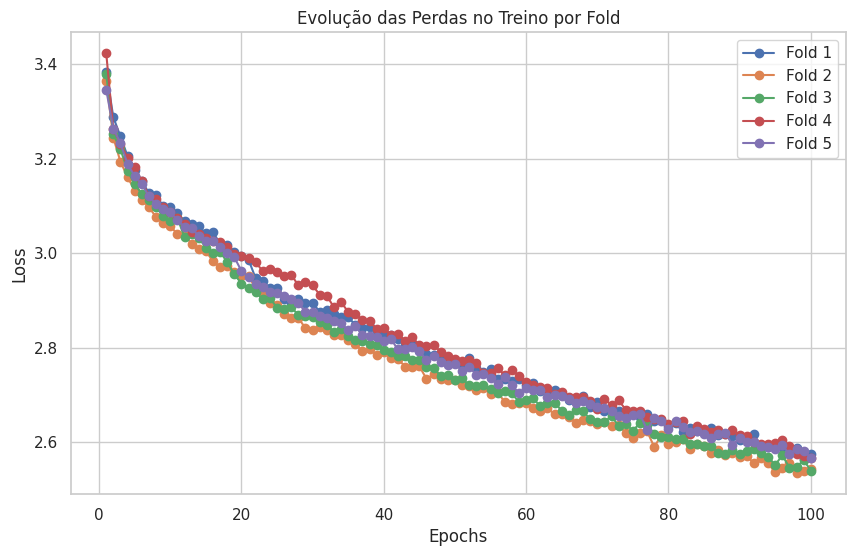

In [ ]:
num_folds = len(fold_losses_train)

plt.figure(figsize=(10, 6))

for fold in range(1, num_folds + 1):
    epochs = range(1, len(fold_losses_train[fold]['mtl_train_losses']) + 1)
    losses = fold_losses_train[fold]['mtl_train_losses']
    plt.plot(epochs, losses, marker='o', label=f'Fold {fold}')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolução das Perdas no Treino por Fold')
plt.legend()
plt.grid(True)

loss_graph_mtl = "/tmp/loss-by-fold-mtl.png"
plt.savefig(loss_graph_mtl)

plt.show()

In [ ]:
print(fold_losses_train[1])

{'mtl_train_losses': [3.3839533449558727, 3.2874199741342096, 3.2469841884763055, 3.204973516839274, 3.1756277070956282, 3.1533537661091664, 3.1264725481526234, 3.1219701579447543, 3.0998427198174294, 3.0973766720696783, 3.085637660508745, 3.067586842547642, 3.0622709239466808, 3.0566952791106834, 3.0416049568840626, 3.04430499773347, 3.020285489853848, 3.0162183555324424, 3.0034455864616993, 2.993548389231221, 2.9860849219761536, 2.9466229784354736, 2.940361219845461, 2.9260229006242215, 2.9266782999038696, 2.9021786237030884, 2.8954891957593767, 2.9019431411550287, 2.893932471114598, 2.8947345326455793, 2.8760468571373585, 2.8796374128105935, 2.871308408426435, 2.865162211857485, 2.865459803784831, 2.847333582599511, 2.840985618280561, 2.8430619387144453, 2.8336866169833064, 2.8287410374437827, 2.826723313063718, 2.8184530641255754, 2.8063086525777754, 2.8087695716472156, 2.7929921136813216, 2.7860572204161227, 2.7838080572278314, 2.7815188370393904, 2.77692394310169, 2.7711554645152

##### **during validation**

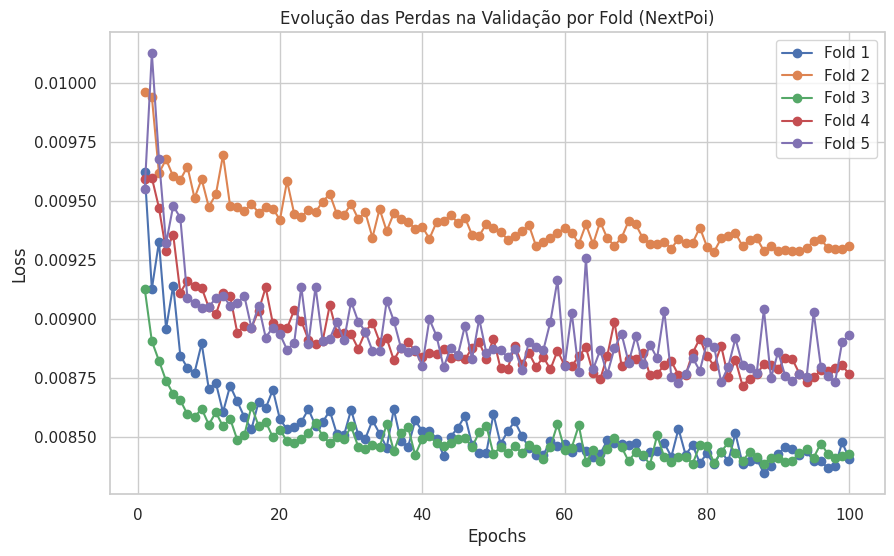

In [ ]:
num_folds = 5

plt.figure(figsize=(10, 6))

for fold in range(1, num_folds + 1):
    epochs = range(1, 100 + 1)
    losses = fold_losses_val[fold]['next_val_losses']
    plt.plot(epochs, losses, marker='o', label=f'Fold {fold}')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolução das Perdas na Validação por Fold (NextPoi)')
plt.legend()
plt.grid(True)

loss_graph_val_next = "/tmp/loss-by-fold-val-next.png"
plt.savefig(loss_graph_val_next)

plt.show()

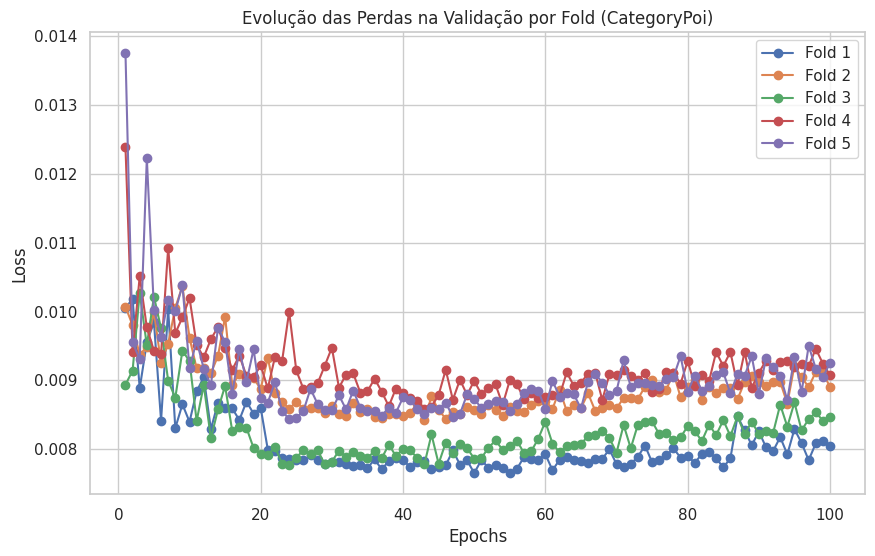

In [ ]:
num_folds = 5

plt.figure(figsize=(10, 6))

for fold in range(1, num_folds + 1):
    epochs = range(1, 100 + 1)
    losses = fold_losses_val[fold]['category_val_losses']
    plt.plot(epochs, losses, marker='o', label=f'Fold {fold}')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolução das Perdas na Validação por Fold (CategoryPoi)')
plt.legend()
plt.grid(True)

loss_graph_val_category = "/tmp/loss-by-fold-val-category.png"
plt.savefig(loss_graph_val_category)

plt.show()

### **saving results**

In [ ]:
model_name_next = 'mtl-next'
model_name_category = 'mtl-category'
state = 'alabama'

def _classification_report(y_true, y_pred, id_to_name, fold_num):
    report = classification_report(y_true, y_pred, zero_division=1, output_dict=True)
    metrics_df = pd.DataFrame(report).transpose()
    metrics_df = metrics_df.drop(columns='support')
    metrics_df.rename(index=id_to_name, inplace=True)
    metrics_df = metrics_df.transpose()
    metrics_df = metrics_df.map(lambda x: f"{x * 100:.1f}")
    accuracy = f"{report['accuracy'] * 100:.1f}"

    return metrics_df, accuracy

agg_metrics_list_next = []
metrics_list_next = []

agg_metrics_list_category = []
metrics_list_category = []

for fold in fold_results_test:
    y_true_next = fold_results_test[fold]['test_next_true']
    y_pred_next = fold_results_test[fold]['test_next_pred']
    report_next, accuracy_next = _classification_report(y_true_next, y_pred_next, id_to_name, fold)

    y_true_category = fold_results_test[fold]['test_category_true']
    y_pred_category = fold_results_test[fold]['test_category_pred']
    report_category, accuracy_category = _classification_report(y_true_category, y_pred_category, id_to_name, fold)

    df_metrics_next = report_next.copy()
    df_metrics_next.reset_index(inplace=True)
    df_metrics_next = df_metrics_next.rename(columns={'index': 'Metricas'})
    path_df = f'/tmp/next-metrics-fold{fold}.csv'
    df_metrics_next.to_csv(path_df)

    df_metricscategory = report_category.copy()
    df_metricscategory.reset_index(inplace=True)
    df_metricscategory = df_metricscategory.rename(columns={'index': 'Metricas'})
    path_df = f'/tmp/category-metrics-fold{fold}.csv'
    df_metricscategory.to_csv(path_df)

    # primeiro csv que gera um grafico
    agg_metrics_next = {
        'fold': fold,
        'model': model_name_next,
        'accuracy': accuracy_next,
        'macro avg': report_next.loc['f1-score', 'macro avg'],
        'weighted avg': report_next.loc['f1-score', 'weighted avg'],
        'state': state
    }
    agg_metrics_list_next.append(agg_metrics_next)

    agg_metrics_category = {
        'fold': fold,
        'model': model_name_category,
        'accuracy': accuracy_category,
        'macro avg': report_category.loc['f1-score', 'macro avg'],
        'weighted avg': report_category.loc['f1-score', 'weighted avg'],
        'state': state
    }
    agg_metrics_list_category.append(agg_metrics_category)

    # segundo csv que gera a tabela
    for categoria in report_next.columns:
        if categoria not in ['macro avg', 'weighted avg']:
            next_metrics = {
                'precision': report_next.loc['precision', categoria],
                'recall': report_next.loc['recall', categoria],
                'f1-score': report_next.loc['f1-score', categoria],
                'category': categoria,
                'accuracy': accuracy_next,
                'model': model_name_next,
                'state': state
            }
            metrics_list_next.append(next_metrics)

    for categoria in report_category.columns:
        if categoria not in ['macro avg', 'weighted avg']:
            next_metrics = {
                'precision': report_category.loc['precision', categoria],
                'recall': report_category.loc['recall', categoria],
                'f1-score': report_category.loc['f1-score', categoria],
                'category': categoria,
                'accuracy': accuracy_category,
                'model': model_name_category,
                'state': state
            }
            metrics_list_category.append(next_metrics)

agg_metrics_df_next = pd.DataFrame(agg_metrics_list_next)
category_metrics_next = pd.DataFrame(metrics_list_next)

agg_metrics_df_category = pd.DataFrame(agg_metrics_list_category)
category_metrics_category = pd.DataFrame(metrics_list_category)

In [ ]:
agg_metrics_df_next.to_csv(path_agg_metrics_next, index=False)
category_metrics_next.to_csv(path_category_metrics_next, index=False)

agg_metrics_df_category.to_csv(path_agg_metrics_category, index=False)
category_metrics_category.to_csv(path_category_metrics_category, index=False)

In [ ]:
model_and_train_params = {
  'embed_dim': 100,
  'shared_layer_size': 256,
  'num_classes': 7,
  'num_layers': 4,
  'num_heads': 8,
  'seq_length': 9,
  'lr': 0.06,
  'num_epochs': 100,
  'n_splits': 5,
  'weight_decay': 1e-6
}

In [ ]:
mlflow.end_run()

In [ ]:
import tempfile
import os

with mlflow.start_run(run_name='mtlpoi'):
    mlflow.log_params(model_and_train_params)
    torch.save(model.state_dict(), "mtlpoi.pth")
    mlflow.log_artifact("mtlpoi.pth", "models")
    mlflow.log_artifact(loss_graph_mtl, "train losses")
    mlflow.log_artifact(loss_graph_val_next, "val losses")
    mlflow.log_artifact(loss_graph_val_category, "val losses")
    mlflow.log_artifact(metric_by_fold_nextpoi, "distribution test metrics")
    mlflow.log_artifact(metric_by_fold_categorypoi, "distribution test metrics")

    flops_df = pd.DataFrame.from_dict(flops, orient='index')

    flops_df_path = '/tmp/flops.csv'
    flops_df.to_csv(flops_df_path)

    mlflow.log_artifact(flops_df_path, "FLOPS")

    with tempfile.TemporaryDirectory() as tmpdir:
        metrics_df_next_path = os.path.join(tmpdir, "metrics_df_next.csv")
        metrics_df_category_path = os.path.join(tmpdir, "metrics_df_category.csv")

        metrics_df_next.to_csv(metrics_df_next_path, index=False)
        metrics_df_category.to_csv(metrics_df_category_path, index=False)

        mlflow.log_artifact(metrics_df_next_path, "next test")
        mlflow.log_artifact(metrics_df_category_path, "category test")

        for fold in fold_results_test:
          path_df_next = f'/tmp/next-metrics-fold{fold}.csv'
          mlflow.log_artifact(path_df_next, "test metrics next")

          path_df_category = f'/tmp/category-metrics-fold{fold}.csv'
          mlflow.log_artifact(path_df_category, "test metrics category")


2024/10/29 17:01:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run mtlpoi at: https://dagshub.com/ingredalmeida1/poc.mlflow/#/experiments/1/runs/169969706a0848a98391ef0dca2c45a6.
2024/10/29 17:01:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/ingredalmeida1/poc.mlflow/#/experiments/1.
